In [ ]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torchhttps://docs.github.com/en/get-started/quickstart/hello-world
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

from IPython.display import display
import ipywidgets as widgets

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [ ]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [ ]:
import opendatasets as od
import pandas as pd
od.download('https://www.kaggle.com/datasets/gauravsahani/indian-currency-notes-classifier')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Ajay Sasane
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/gauravsahani/indian-currency-notes-classifier


100%|██████████| 20.0M/20.0M [00:00<00:00, 62.3MB/s]

In [ ]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for facial expression recognition.
train_transform = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 224)
    transforms.Resize((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# Construct datasets.
train_dataset = datasets.ImageFolder("indian-currency-notes-classifier/Train", transform=train_transform)
test_dataset = datasets.ImageFolder("indian-currency-notes-classifier/Test", transform=test_transform)

# Define the desired ratio for train and evaluation data (e.g., 90% train, 10% evaluation)
train_ratio = 0.9
val_ratio = 1 - train_ratio

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 153 samples
Train set has 137 samples
Validation set has 16 samples
Test set has 42 samples


In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32

# Construct data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

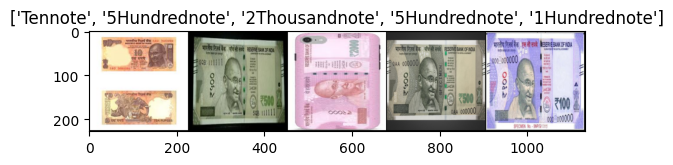

In [ ]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['1Hundrednote', '2Hundrednote', '2Thousandnote', '5Hundrednote', 'Fiftynote', 'Tennote', 'Twentynote']

imshow(out, title=[class_names[x] for x in classes])

# 3 Model

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1), # TODO: set a convolution layer with out_channels=256, kernel_size=3, stride=1, padding=1
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0), # TODO: set a max pooling layer with kernel_size=4, stride=4, padding=0
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256), # TODO: fill in the correct input feature size after flatten. The tensor shape before flatten is (256, 14, 14)
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 7]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyCNN()
model = model.to(device)

# 4 Define Loss and Optimizer

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# 5 Train and Validation

In [ ]:
# The number of training epochs.
n_epochs = 100

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 001/100] Train: loss=1.96671, acc=0.13819 | Valid: loss=1.96731, acc=0.06250


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 002/100] Train: loss=1.92986, acc=0.17917 | Valid: loss=1.94630, acc=0.06250


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 003/100] Train: loss=1.88566, acc=0.17847 | Valid: loss=1.93709, acc=0.12500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 004/100] Train: loss=1.77733, acc=0.31389 | Valid: loss=1.78171, acc=0.18750


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 005/100] Train: loss=1.57232, acc=0.47708 | Valid: loss=1.64176, acc=0.25000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 006/100] Train: loss=1.42999, acc=0.44514 | Valid: loss=2.10461, acc=0.18750


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 007/100] Train: loss=1.47948, acc=0.48611 | Valid: loss=1.26532, acc=0.62500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 008/100] Train: loss=1.28001, acc=0.51667 | Valid: loss=1.38190, acc=0.18750


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 009/100] Train: loss=1.07511, acc=0.60208 | Valid: loss=1.51802, acc=0.37500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 010/100] Train: loss=0.98388, acc=0.61736 | Valid: loss=1.37621, acc=0.31250


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 011/100] Train: loss=1.02501, acc=0.58958 | Valid: loss=1.75409, acc=0.50000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 012/100] Train: loss=1.06112, acc=0.58958 | Valid: loss=1.09489, acc=0.68750


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 013/100] Train: loss=0.92379, acc=0.66389 | Valid: loss=1.10034, acc=0.62500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 014/100] Train: loss=0.73497, acc=0.77153 | Valid: loss=1.69734, acc=0.18750


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 015/100] Train: loss=0.67802, acc=0.75903 | Valid: loss=1.06734, acc=0.56250


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 016/100] Train: loss=0.50379, acc=0.82778 | Valid: loss=1.77990, acc=0.25000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 017/100] Train: loss=0.44643, acc=0.86806 | Valid: loss=0.99960, acc=0.62500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 018/100] Train: loss=0.40444, acc=0.86875 | Valid: loss=1.35940, acc=0.50000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 019/100] Train: loss=0.29519, acc=0.88750 | Valid: loss=1.09770, acc=0.62500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 020/100] Train: loss=0.21669, acc=0.93125 | Valid: loss=0.91348, acc=0.62500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 021/100] Train: loss=0.17703, acc=0.94653 | Valid: loss=1.05782, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 022/100] Train: loss=0.11995, acc=0.96250 | Valid: loss=1.05653, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 023/100] Train: loss=0.07880, acc=0.98750 | Valid: loss=0.97430, acc=0.68750


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 024/100] Train: loss=0.06594, acc=1.00000 | Valid: loss=0.94613, acc=0.68750


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 025/100] Train: loss=0.04498, acc=0.99375 | Valid: loss=1.18674, acc=0.62500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 026/100] Train: loss=0.03762, acc=1.00000 | Valid: loss=1.19151, acc=0.62500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 027/100] Train: loss=0.02970, acc=1.00000 | Valid: loss=0.93262, acc=0.68750


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 028/100] Train: loss=0.02589, acc=1.00000 | Valid: loss=1.22648, acc=0.68750


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 029/100] Train: loss=0.02384, acc=0.99375 | Valid: loss=0.98217, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 030/100] Train: loss=0.01745, acc=1.00000 | Valid: loss=1.06705, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 031/100] Train: loss=0.00819, acc=1.00000 | Valid: loss=1.06257, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 032/100] Train: loss=0.00669, acc=1.00000 | Valid: loss=1.09930, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 033/100] Train: loss=0.00497, acc=1.00000 | Valid: loss=1.13989, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 034/100] Train: loss=0.00542, acc=1.00000 | Valid: loss=1.14696, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 035/100] Train: loss=0.00549, acc=1.00000 | Valid: loss=1.17246, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 036/100] Train: loss=0.00403, acc=1.00000 | Valid: loss=1.50967, acc=0.62500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 037/100] Train: loss=0.00356, acc=1.00000 | Valid: loss=1.19876, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 038/100] Train: loss=0.00226, acc=1.00000 | Valid: loss=1.11828, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 039/100] Train: loss=0.00222, acc=1.00000 | Valid: loss=1.16368, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 040/100] Train: loss=0.00181, acc=1.00000 | Valid: loss=1.23496, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 041/100] Train: loss=0.00167, acc=1.00000 | Valid: loss=1.27475, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 042/100] Train: loss=0.00148, acc=1.00000 | Valid: loss=1.28667, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 043/100] Train: loss=0.00142, acc=1.00000 | Valid: loss=1.28143, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 044/100] Train: loss=0.00133, acc=1.00000 | Valid: loss=1.30222, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 045/100] Train: loss=0.00132, acc=1.00000 | Valid: loss=1.32706, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 046/100] Train: loss=0.00121, acc=1.00000 | Valid: loss=1.37104, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 047/100] Train: loss=0.00105, acc=1.00000 | Valid: loss=1.41934, acc=0.68750


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 048/100] Train: loss=0.00103, acc=1.00000 | Valid: loss=1.38085, acc=0.68750


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 049/100] Train: loss=0.00088, acc=1.00000 | Valid: loss=1.36711, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 050/100] Train: loss=0.00085, acc=1.00000 | Valid: loss=1.35347, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 051/100] Train: loss=0.00082, acc=1.00000 | Valid: loss=1.36848, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 052/100] Train: loss=0.00078, acc=1.00000 | Valid: loss=1.38396, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 053/100] Train: loss=0.00077, acc=1.00000 | Valid: loss=1.38467, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 054/100] Train: loss=0.00068, acc=1.00000 | Valid: loss=1.39614, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 055/100] Train: loss=0.00074, acc=1.00000 | Valid: loss=1.41325, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 056/100] Train: loss=0.00057, acc=1.00000 | Valid: loss=1.44859, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 057/100] Train: loss=0.00066, acc=1.00000 | Valid: loss=1.46107, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 058/100] Train: loss=0.00066, acc=1.00000 | Valid: loss=1.45639, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 059/100] Train: loss=0.00069, acc=1.00000 | Valid: loss=1.43575, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 060/100] Train: loss=0.00057, acc=1.00000 | Valid: loss=1.46366, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 061/100] Train: loss=0.00051, acc=1.00000 | Valid: loss=1.50025, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 062/100] Train: loss=0.00052, acc=1.00000 | Valid: loss=1.52778, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 063/100] Train: loss=0.00050, acc=1.00000 | Valid: loss=1.50585, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 064/100] Train: loss=0.00044, acc=1.00000 | Valid: loss=1.48072, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 065/100] Train: loss=0.00042, acc=1.00000 | Valid: loss=1.48404, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 066/100] Train: loss=0.00039, acc=1.00000 | Valid: loss=1.48364, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 067/100] Train: loss=0.00037, acc=1.00000 | Valid: loss=1.48687, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 068/100] Train: loss=0.00036, acc=1.00000 | Valid: loss=1.50163, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 069/100] Train: loss=0.00037, acc=1.00000 | Valid: loss=1.51904, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 070/100] Train: loss=0.00039, acc=1.00000 | Valid: loss=1.51803, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 071/100] Train: loss=0.00035, acc=1.00000 | Valid: loss=1.51688, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 072/100] Train: loss=0.00030, acc=1.00000 | Valid: loss=1.49683, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 073/100] Train: loss=0.00029, acc=1.00000 | Valid: loss=1.49811, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 074/100] Train: loss=0.00033, acc=1.00000 | Valid: loss=1.51138, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 075/100] Train: loss=0.00029, acc=1.00000 | Valid: loss=1.53748, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 076/100] Train: loss=0.00030, acc=1.00000 | Valid: loss=1.54592, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 077/100] Train: loss=0.00028, acc=1.00000 | Valid: loss=1.53974, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 078/100] Train: loss=0.00030, acc=1.00000 | Valid: loss=1.54920, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 079/100] Train: loss=0.00028, acc=1.00000 | Valid: loss=1.52709, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 080/100] Train: loss=0.00025, acc=1.00000 | Valid: loss=1.51614, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 081/100] Train: loss=0.00023, acc=1.00000 | Valid: loss=1.51663, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 082/100] Train: loss=0.00023, acc=1.00000 | Valid: loss=1.53360, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 083/100] Train: loss=0.00024, acc=1.00000 | Valid: loss=1.56494, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 084/100] Train: loss=0.00022, acc=1.00000 | Valid: loss=1.58314, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 085/100] Train: loss=0.00020, acc=1.00000 | Valid: loss=1.57807, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 086/100] Train: loss=0.00021, acc=1.00000 | Valid: loss=1.57574, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 087/100] Train: loss=0.00020, acc=1.00000 | Valid: loss=1.57270, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 088/100] Train: loss=0.00018, acc=1.00000 | Valid: loss=1.58000, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 089/100] Train: loss=0.00019, acc=1.00000 | Valid: loss=1.59416, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 090/100] Train: loss=0.00020, acc=1.00000 | Valid: loss=1.61379, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 091/100] Train: loss=0.00020, acc=1.00000 | Valid: loss=1.61367, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 092/100] Train: loss=0.00016, acc=1.00000 | Valid: loss=1.59735, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 093/100] Train: loss=0.00018, acc=1.00000 | Valid: loss=1.59577, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 094/100] Train: loss=0.00016, acc=1.00000 | Valid: loss=1.61451, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 095/100] Train: loss=0.00015, acc=1.00000 | Valid: loss=1.62889, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 096/100] Train: loss=0.00017, acc=1.00000 | Valid: loss=1.63004, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 097/100] Train: loss=0.00016, acc=1.00000 | Valid: loss=1.63570, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 098/100] Train: loss=0.00015, acc=1.00000 | Valid: loss=1.63739, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 099/100] Train: loss=0.00014, acc=1.00000 | Valid: loss=1.63405, acc=0.75000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 100/100] Train: loss=0.00014, acc=1.00000 | Valid: loss=1.64286, acc=0.75000


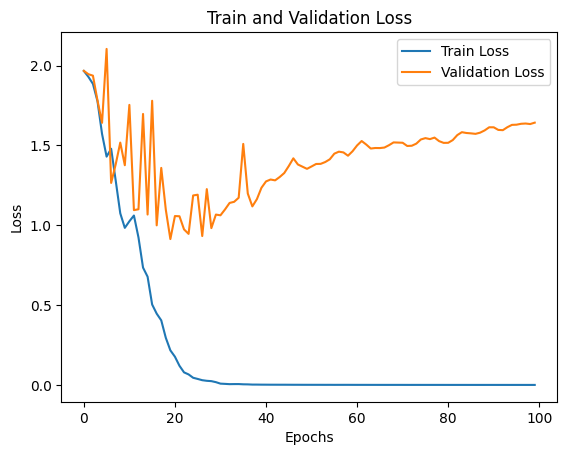

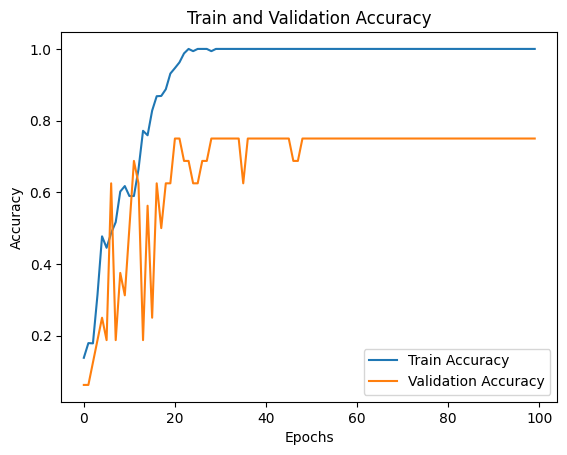

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# 6 Testing




In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/2 [00:00<?, ?it/s]

Test accuracy 0.659375011920929


In [ ]:
def preprocess_image(image_path):
    """Preprocesses the image for model input."""
    image = Image.open(image_path)
    image = test_transform(image).unsqueeze(0)  # Add batch dimension
    return image


In [ ]:
def predict_image(model, image_path, class_names):
    """Predicts the class of an uploaded image."""
    model.eval()  # Ensure the model is in evaluation mode
    image = preprocess_image(image_path).to(device)  # Preprocess the image and move to device
    with torch.no_grad():
        logits = model(image)  # Get model predictions
    probs = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities
    predicted_class = torch.argmax(probs, dim=1).item()  # Get the class with the highest probability
    return class_names[predicted_class], probs[0][predicted_class].item()

FileUpload(value={}, accept='image/*', description='Upload')

Predicted class: 5Hundrednote with confidence 0.41


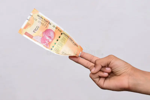

Predicted class: Tennote with confidence 0.38


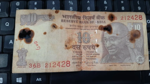

Predicted class: 5Hundrednote with confidence 1.00


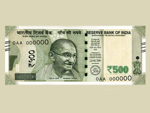

In [ ]:
from IPython.display import display
import ipywidgets as widgets

# Upload button
upload_button = widgets.FileUpload(
    accept='image/*',  # Accept only image files
    multiple=False  # Do not allow multiple uploads
)

def on_upload_change(change):
    # Get the uploaded file
    uploaded_file = list(change['new'].values())[0]
    file_path = uploaded_file['metadata']['name']

    # Save the uploaded file locally
    with open(file_path, 'wb') as f:
        f.write(uploaded_file['content'])

    # Perform prediction
    predicted_class, confidence = predict_image(model, file_path, class_names)
    print(f"Predicted class: {predicted_class} with confidence {confidence:.2f}")

    # Display the image
    img = Image.open(file_path)
    img.thumbnail((150, 150))
    display(img)

upload_button.observe(on_upload_change, names='value')
display(upload_button)


  0%|          | 0/2 [00:00<?, ?it/s]

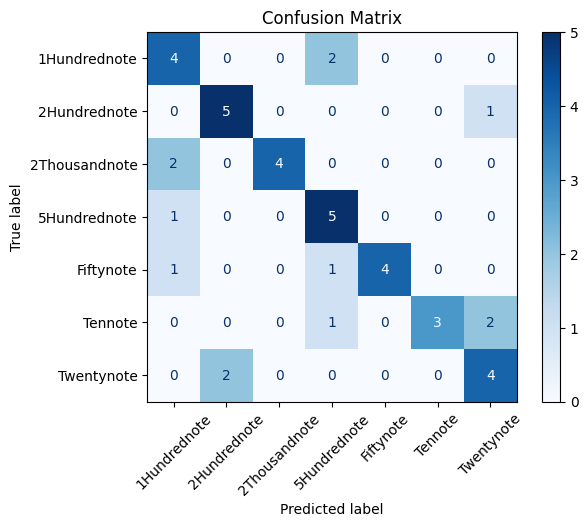

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make sure the model is in eval mode
model.eval()

# Lists to store true labels and predictions
true_labels = []
pred_labels = []

# Iterate over the test set
for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = model(imgs)
    preds = torch.argmax(logits, dim=1)

    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
class_report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
print(class_report)
class_report_df = pd.DataFrame(class_report).transpose()
display(class_report_df)

{'1Hundrednote': {'precision': 0.5, 'recall': 0.6666666666666666, 'f1-score': 0.5714285714285715, 'support': 6}, '2Hundrednote': {'precision': 0.7142857142857143, 'recall': 0.8333333333333334, 'f1-score': 0.7692307692307692, 'support': 6}, '2Thousandnote': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 6}, '5Hundrednote': {'precision': 0.5555555555555556, 'recall': 0.8333333333333334, 'f1-score': 0.6666666666666667, 'support': 6}, 'Fiftynote': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 6}, 'Tennote': {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 6}, 'Twentynote': {'precision': 0.5714285714285714, 'recall': 0.6666666666666666, 'f1-score': 0.6153846153846153, 'support': 6}, 'accuracy': 0.6904761904761905, 'macro avg': {'precision': 0.7630385487528344, 'recall': 0.6904761904761905, 'f1-score': 0.6984824699110413, 'support': 42}, 'weighted avg': {'precision': 0.7630385487528344, 'recall': 0.69047

,precision,recall,f1-score,support
1Hundrednote,0.500000,0.666667,0.571429,6.000000
2Hundrednote,0.714286,0.833333,0.769231,6.000000
2Thousandnote,1.000000,0.666667,0.800000,6.000000
5Hundrednote,0.555556,0.833333,0.666667,6.000000
Fiftynote,1.000000,0.666667,0.800000,6.000000
Tennote,1.000000,0.500000,0.666667,6.000000
Twentynote,0.571429,0.666667,0.615385,6.000000
accuracy,0.690476,0.690476,0.690476,0.690476
macro avg,0.763039,0.690476,0.698482,42.000000
weighted avg,0.763039,0.690476,0.698482,42.000000
